In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Convolution

#### 1D Convolution

In [68]:
# Convolves a 1D array with a kernel
def conv1D(inSignal:np.ndarray,kernel1:np.ndarray)->np.ndarray:
    if(kernel1.shape[0] % 2 == 0):
        pad_size = int((kernel1.shape[0])/2)
        padded_signal = np.pad(inSignal, pad_size, 'constant', constant_values=0)
        new_signal = np.array([])
        # Apply kernel to each pixel
        for i in range(0, padded_signal.shape[0]-pad_size-1):
            sub_signal = padded_signal[i:i+pad_size+1]
            prod = sub_signal*kernel1
            sub_signal_sum = np.sum(prod)
            new_signal = np.append(new_signal, sub_signal_sum)
    else:
        # Padding array with zeros so resulting array is same length as original
        pad_size = int((kernel1.shape[0]-1)/2)
        padded_signal = np.pad(inSignal, pad_size, 'constant', constant_values=0)
        new_signal = np.array([])
        # Apply kernel to each pixel
        for i in range(pad_size, padded_signal.shape[0]-pad_size):
            sub_signal = padded_signal[i-pad_size:i+pad_size+1]
            prod = sub_signal*kernel1
            sub_signal_sum = np.sum(prod)
            new_signal = np.append(new_signal, sub_signal_sum)
    return new_signal

In [67]:
conv1D(np.array([1,1]),np.array([1,1]))

array([1., 2.])

In [55]:
np.convolve(np.array([1,1]),np.array([1,1]),'same')

array([1, 2])

#### 2D Convolution

In [5]:
def conv2D(inImage:np.ndarray,kernel2:np.ndarray)->np.ndarray:
    inImage = cv2.cvtColor(inImage, cv2.COLOR_BGR2GRAY)
    pad_size = int((kernel2.shape[0]-1)/2)
    padded_image = np.pad(inImage, ((pad_size,pad_size),(pad_size,pad_size)), 'constant', constant_values=0)
    new_image = np.zeros(inImage.shape)
    for i in range(pad_size, padded_image.shape[0]-pad_size-1):
        for j in range(pad_size, padded_image.shape[1]-pad_size-1):
            sub_image = padded_image[i-pad_size:i+pad_size+1,j-pad_size:j+pad_size+1]
            prod = sub_image*kernel2
            sub_image_sum = np.sum(prod)
            new_image[i-pad_size,j-pad_size] = sub_image_sum
    return new_image

In [6]:
def mean_ker(size):
    return np.full((size,size),1)/(size*size)

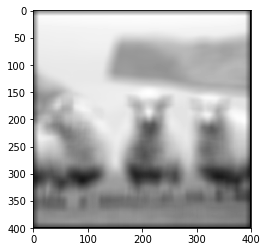

In [25]:
img = cv2.imread("sheep.png")
ker = np.full((23,23),1)
res = conv2D(img,ker)
plt.imshow(res,'gray')

# Image derivatives & blurring

#### Derivatives

In [26]:
def convDerivative(inImage:np.ndarray) -> np.ndarray:
    h,w = inImage.shape[:2]
    der_x = np.zeros((h,w))
    for i in range(h):
        der_x[i] = conv1D(inImage[i], ker)
    der_y = np.zeros((h,w))
    img_trans = np.transpose(inImage)
    for i in range(w):
        der_y[i] = conv1D(img_trans[i], np.transpose(ker))
    der_y = np.transpose(der_y)
    mag = np.sqrt(der_x**2 + der_y**2)
    return mag

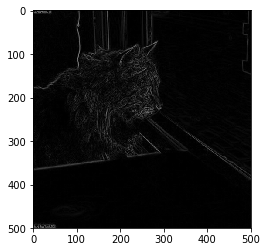

In [19]:
plt.imshow(convDerivative(img),'gray')

#### Blurring

In [71]:
arr = np.array([1,1])
for i in range(10):
    arr = np.convolve(arr,np.array([1,1]))
    print(arr)

[1 2 1]
[1 3 3 1]
[1 4 6 4 1]
[ 1  5 10 10  5  1]
[ 1  6 15 20 15  6  1]
[ 1  7 21 35 35 21  7  1]
[ 1  8 28 56 70 56 28  8  1]
[  1   9  36  84 126 126  84  36   9   1]
[  1  10  45 120 210 252 210 120  45  10   1]
[  1  11  55 165 330 462 462 330 165  55  11   1]


In [132]:
def gaussian_kernel(size):
    arr = np.array([1,1])
    for i in range(size-2):
        arr = np.convolve(arr,np.array([1,1]))
    ker = np.zeros((size,size))
    ker[0] = arr
    ker[size-1] = arr
    ker = np.transpose(ker)
    ker[0] = arr
    ker[size-1] = arr
        ker = ker/np.sum(ker)
    for i in range(1,size):
        for j in range(1,size):
            ker[i,j] = ker[i,0]*ker[0,j]
    return ker

def gkern(l=5, sig=1.):
    """\
    creates gaussian kernel with side length l and a sigma of sig
    """

    ax = np.arange(-l // 2 + 1., l // 2 + 1.)
    xx, yy = np.meshgrid(ax, ax)

    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sig))

    return kernel / np.sum(kernel)

In [96]:
np.sum(gaussian_kernel(175))

1.0

1.0

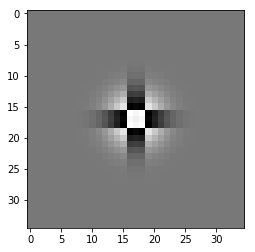

In [166]:
img = cv2.imread("cat.jpg")
ker = gaussian_kernel(35)
# res = conv2D(img,ker)
# plt.imshow(res,'gray')
plt.imshow(ker,'gray')
np.sum(ker)

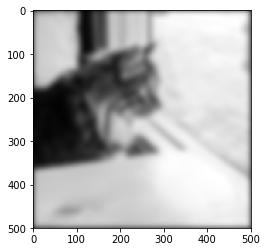

In [155]:
img = cv2.imread("cat.jpg")
ker = gkern(33,7)
res = conv2D(img,ker)
plt.imshow(res,'gray')
# plt.imshow(ker,'gray')

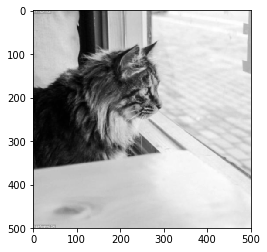

In [124]:
res2 = cv2.GaussianBlur(img,(3,3),0)
res2 = cv2.cvtColor(res2, cv2.COLOR_BGR2GRAY)
plt.imshow(res2, 'gray')

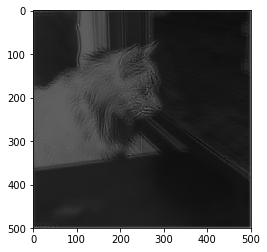

In [125]:
plt.imshow(res2-res*1.5, 'gray')